In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from pysankey2 import Sankey
import matplotlib as mpl
from pathlib import Path
import os.path as op
import pandas as pd
import numpy as np
import json
import os

from dataclasses import dataclass, field
from typing import Any, List, Dict, Optional

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

In [4]:
from cluster import reindex_clusters

In [5]:
# Join similarity matrices
# sim_paths = Path('../data/similarity/')

# df_similarity = None
# for f in sim_paths.rglob('*h5'):
#     dataset, atlas = str(f).split('/')[-1].split('_')[0:2]
#     tdf = pd.read_hdf(f)
#     tdf['dataset'], tdf['atlas'] = dataset, atlas
    
#     if df_similarity is None:
#         df_similarity = tdf
#     else:
#         df_similarity = pd.concat([df_similarity, tdf])

# pd.to_pickle(df_similarity, '../data/clustering/preprocessed_similarity.pkl')

In [6]:
def compare_clustering(cluster_definitions: pd.DataFrame, cluster_data: pd.DataFrame,
                       subject_similarity: pd.DataFrame, dataset: str, across: str="atlas",
                       plot: bool=True):
    if across != "atlas":
        raise NotImplementedError("Only across atlas comparisons are currently supported.")

    # Reduce dataframe to only contain dataset of interest
    cluster_definitions = cluster_definitions[cluster_definitions['dataset'] == dataset]
    cluster_data = cluster_data[cluster_data['dataset'] == dataset]
    subject_similarity = subject_similarity[subject_similarity['dataset'] == dataset]

    # Set up some convenience variables and lambdas
    da = ['dataset', 'atlas']  # Regularly used for subsampling dataframe
    cois = ['subject', 'session', 'dataset', 'atlas']  # Used to subsample subject dataframe
    combos = cluster_definitions.value_counts(da).index  # Is sorted in order of most->fewest clusters 

    # Prepare cluster sorting
    sliced_da = lambda df, ds, at: df[(df['dataset'] == ds) & (df['atlas'] == at)]
    get_signatures = lambda df, c: np.stack([np.reshape(_, -1) for _ in sliced_da(df, *c)['signature']])
    cluster_orders = {}

    # Extract info from reference parcellation (the one with the most clusters)
    c1 = combos[0]
    s1 = get_signatures(cluster_definitions, c1)
    cluster_orders[c1[1]] = np.arange(len(s1)) # C#[1] is just the atlas name

    # Set up subject matrix for cluster assignment, and populate with reference
    subject_similarity = subject_similarity[cois].groupby(['subject', 'session']).max()
    subject_similarity[c1[1]] = reindex_clusters(sliced_da(cluster_data, *c1)['labels'].values[0],
                                                 order=cluster_orders[c1[1]])

    # Match clusters from other parcellations
    for idx, c2 in enumerate(combos[1:]):
        s2 = get_signatures(cluster_definitions, c2)

        # Compute similarity of clusters, and match them
        cost = cdist(s1, s2, metric='cosine')
        reorder = linear_sum_assignment(cost)
        cluster_orders[c2[1]] = np.argsort(reorder[1])

        # Assign cluster memberships (with updated indice) back to subjects/sessions
        v = sliced_da(cluster_data, *c2)['labels']
        subject_similarity[c2[1]] = reindex_clusters(sliced_da(cluster_data, *c2)['labels'].values[0],
                                                     order=cluster_orders[c2[1]])
    
    # Create utility dataframes and perform Sankey plotting
    if plot:
        # Set colourmap for plot
        # cm = mpl.cm.get_cmap('Dark2').colors
        cm = ["#9d973f", "#b253c0", "#64ac48", "#6768cc", "#c67f40", "#5d94ce",
              "#d04a3e", "#4aac8b", "#d14788", "#bb7fc1", "#bb6271"]
        # From : http://medialab.github.io/iwanthue/

        # Determine column sorting (TODO: make less hard-coded?)
        order = ['aal', 'cc2', 'hox', 'des']
        
        # Rename columns and establish the (sequential) sorting of clusters
        col_names = {a: 'layer'+str(_+1) for _, a in enumerate(order)}
        cords = {'layer'+str(_+1): np.arange(len(cluster_orders[a])) for _, a in enumerate(order)}
        
        # Create a slimmed down dataframe for Sankey
        sankey_df = subject_similarity[order]
        sankey_df = sankey_df.rename(columns=col_names)
        sankey_df = sankey_df.reset_index().drop(columns=['subject', 'session'])

        color_dict = {_: cm[_] for _ in range(len(s1))}
        
        # Plot
        subject_clustering = Sankey(sankey_df, colorMode='global', stripColor='gray',
                                    colorDict=color_dict, layerLabels=cords)
        subject_clustering.plot(figSize=(15, 15), fontSize=0)

    return cluster_definitions, cluster_data, subject_similarity

In [7]:
@dataclass
class ClusteringFrames:
    definitions: Optional[pd.DataFrame] = None
    data: Optional[pd.DataFrame] = None
    subjects: Optional[pd.DataFrame] = None
    plot: Optional[Any] = None
    combinations: List = field(default_factory=list)
    sorting: Dict = field(default_factory=lambda: {})
    plot_order: List = field(default_factory=lambda: ['aal', 'cc2', 'hox', 'des'])


# Utility function to slice dataframes
def get_df_slice(df, ds, at):
    return df[(df['dataset'] == ds) & (df['atlas'] == at)]


# Utility function to get and stack cluster signatures
def get_signatures(df, c):
    return np.stack([np.reshape(_, -1) for _ in get_df_slice(df, *c)['signature']])


def compare_clustering_dc(cluster_definitions: pd.DataFrame, cluster_data: pd.DataFrame,
                       subject_similarity: pd.DataFrame, dataset: str, across: str="atlas",
                       plot: bool=True):
    if across != "atlas":
        raise NotImplementedError("Only across atlas comparisons are currently supported.")

    # Create data class for clustering informations
    cf = ClusteringFrames()

    # Reduce dataframe to only contain dataset of interest
    cf.definitions = cluster_definitions[cluster_definitions['dataset'] == dataset]
    cf.data = cluster_data[cluster_data['dataset'] == dataset]
    cf.subjects = subject_similarity[subject_similarity['dataset'] == dataset]
    
    # Set up some convenience variables and lambdas
    da = ['dataset', 'atlas']  # Regularly used for subsampling dataframe
    cois = ['subject', 'session', 'dataset', 'atlas']  # Used to subsample subject dataframe
    cf.combinations = cf.definitions.value_counts(da).index  # Is sorted in order of most->fewest clusters 

    # Extract info from reference parcellation (the one with the most clusters)
    dataset_atlas = cf.combinations[0]
    sig_ref = get_signatures(cf.definitions, dataset_atlas)
    cf.sorting[dataset_atlas[1]] = np.arange(len(sig_ref)) # dataset_atlas[1] is the atlas name

    # Set up subject matrix for cluster assignment, and populate with reference
    cf.subjects = cf.subjects[cois].groupby(['subject', 'session']).max()
    labels = get_df_slice(cf.data, *dataset_atlas)['labels'].values[0]
    cf.subjects[dataset_atlas[1]] = reindex_clusters(labels, order=cf.sorting[dataset_atlas[1]])

    # Match clusters from other parcellations
    for idx, da2 in enumerate(cf.combinations[1:]):
        # da2 = dataset_atlas_2
        sig_targ = get_signatures(cf.definitions, da2)

        # Compute similarity of clusters, and match them
        cost = cdist(sig_ref, sig_targ, metric='cosine')
        reorder = linear_sum_assignment(cost)
        cf.sorting[da2[1]] = np.argsort(reorder[1])

        # Assign cluster memberships (with updated indice) back to subjects/sessions
        labels = get_df_slice(cf.data, *da2)['labels'].values[0]
        cf.subjects[da2[1]] = reindex_clusters(labels, order=cf.sorting[da2[1]])

    # Create utility dataframes and perform Sankey plotting
    if plot:
        # Set colourmap for plot
        # cm = mpl.cm.get_cmap('Dark2').colors
        cm = ["#9d973f", "#b253c0", "#64ac48", "#6768cc", "#c67f40", "#5d94ce",
              "#d04a3e", "#4aac8b", "#d14788", "#bb7fc1", "#bb6271"]
        # From : http://medialab.github.io/iwanthue/
        
        # Rename columns and establish the (sequential) sorting of clusters
        col_names = {atlas: 'layer'+str(_+1)
                     for _, atlas in enumerate(cf.plot_order)}
        cords = {'layer'+str(_+1): np.arange(len(cf.sorting[atlas]))
                 for _, atlas in enumerate(cf.plot_order)}
        
        # Create a slimmed down dataframe for Sankey
        sankey_df = cf.subjects[cf.plot_order]
        sankey_df = sankey_df.rename(columns=col_names)
        sankey_df = sankey_df.reset_index().drop(columns=['subject', 'session'])

        color_dict = {_: cm[_] for _ in range(len(sig_ref))}
        
        # Plot
        cf.plot = Sankey(sankey_df, colorMode='global', stripColor='gray', colorDict=color_dict, layerLabels=cords)
        cf.plot.plot(figSize=(15, 15), fontSize=0)

    return cf

In [8]:
df_cluster_def = pd.read_pickle('../data/clustering/cluster_definitions.pkl')
df_cluster_dat = pd.read_pickle('../data/clustering/cluster_membership.pkl')
df_similarity = pd.read_pickle('../data/clustering/preprocessed_similarity.pkl')

def cc_easy(dataset, **kwargs):
    return compare_clustering(df_cluster_def, df_cluster_dat, df_similarity, dataset, **kwargs)

def cc_easy_dc(dataset, **kwargs):
    return compare_clustering_dc(df_cluster_def, df_cluster_dat, df_similarity, dataset, **kwargs)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


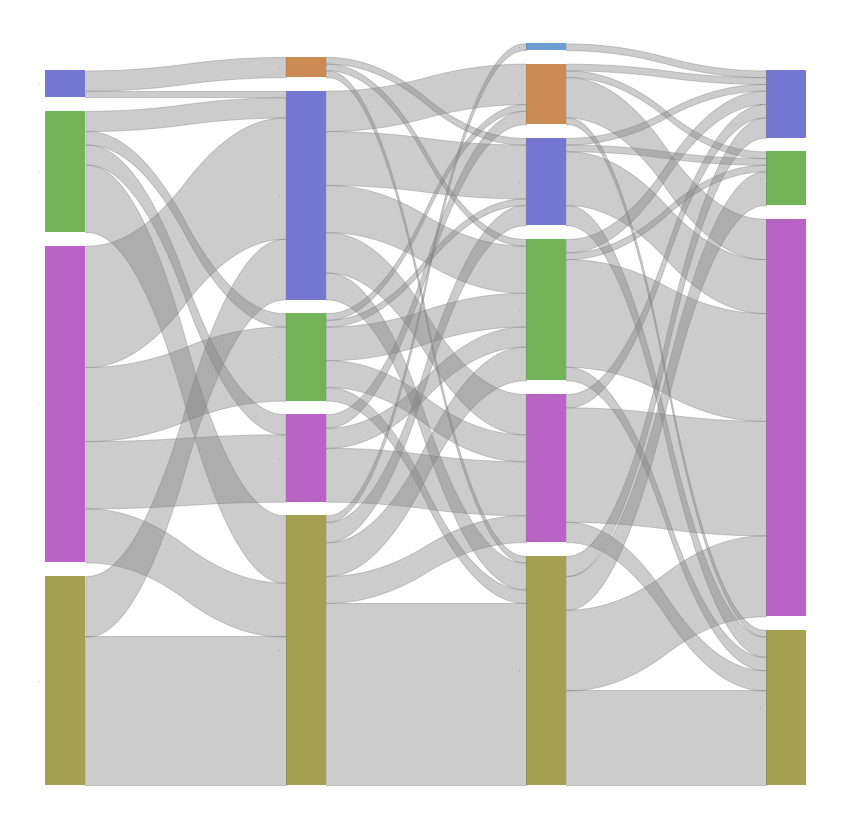

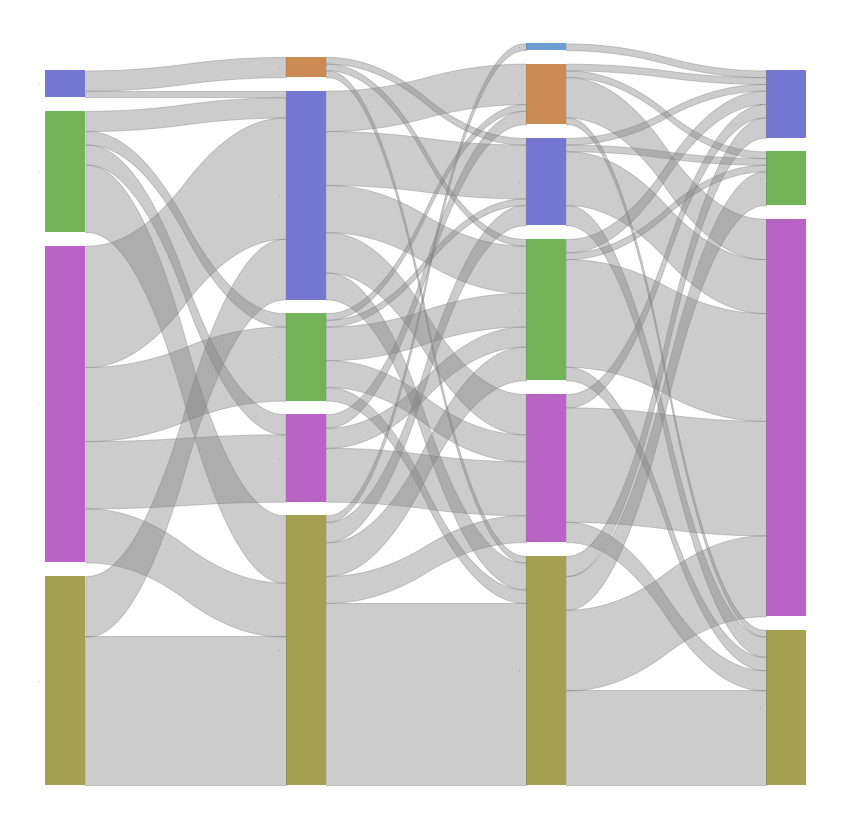

In [9]:
cluster_definitions, cluster_data, subject_similarity = cc_easy('BNU2', plot=True)

cf = cc_easy_dc('BNU2', plot=True)

In [84]:
tdf = []
for idx, c1 in enumerate(combos):
    for jdx, c2 in enumerate(combos[idx+1:]):
        l1 = sliced_da(df_cluster_dat, *c1).labels.values[0]
        l2 = sliced_da(df_cluster_dat, *c2).labels.values[0]
        tmp = l1 == l2
        
        tdf += [{
            "dataset": c1[0],
            "atlas1": c1[1],
            "atlas2": c2[1],
            "ARI": adjusted_rand_score(l1, l2),
            "AMI": adjusted_mutual_info_score(l1, l2),
            "Percent Overlap": np.sum(tmp)/len(tmp)*100
        }]

df_cluster_overlaps = pd.DataFrame.from_dict(tdf)
df_cluster_overlaps

,dataset,atlas1,atlas2,ARI,AMI,Percent Overlap
0,SWU1,aal,cc2,0.176521,0.200721,44.067797
1,SWU1,aal,hox,0.044331,0.058790,23.728814
2,SWU1,aal,des,0.050072,0.112936,27.118644
3,SWU1,cc2,hox,0.335745,0.362042,61.016949
4,SWU1,cc2,des,0.032553,0.093051,38.983051
5,SWU1,hox,des,0.176297,0.255487,33.898305
